### Part 1: Map to Menu 

In [1]:
"""
read in retail data and MeetFresh menu

"""

import pandas as pd

#retail_data
retail_data= pd.read_csv("scanner_data.csv")

#MeetFresh menu
#Combine two sheets and adjust data type
drink=pd.read_excel("MeetFresh_Menu_Plano.xlsx",sheet_name='Drink')
food=pd.read_excel("MeetFresh_Menu_Plano.xlsx",sheet_name='Food')
menu=pd.concat([food, drink], axis=0, ignore_index=True)
menu=menu.fillna(0)
float_col = menu.select_dtypes(include=['float64'])
for col in float_col.columns.values:
    menu[col] = menu[col].astype('int64')   
#menu.info(verbose=True)
#menu.head()

In [2]:
"""
Map top categories in retail data to meetFresh menu categories

Mapping stored in datafram: cate_map

"""

top16cate = dict(retail_data['SKU_Category'].value_counts().head(16))
#Filter retail data by only keeping top 16 SKU Category
#retail16=retail_data.loc[retail_data['SKU_Category'].isin(cate_map['SKU_Category'].tolist())]
#retail16.groupby('SKU_Category')['SKU'].nunique()

top16menu = ['Signature Series', 'Dessert Combo', 'Milk Teas','Fresh Milk','Fluffy', 
       'Fruit Series','Shaved Ice', 'Tofu Pudding', 'Egg Waffle', 'Small Bites', 
       'Teas','Herbal Teas',  'Almond Drink',
       'Winter Melon Teas', 'Slush', 'Create Your Own']

sku_cate_map = {'SKU_Category': top16cate.keys(), 'Menu_Category': top16menu}
cate_map = pd.DataFrame(data=sku_cate_map)

In [3]:
"""
Map top SKUs in each category to meetFresh menu Item_IDs

Mapping stored in datafram: item_map

"""
i = 0
item_map = pd.DataFrame({"SKU_Category":[],"SKU":[],"Menu_Category":[],"Item_ID":[]})
while i < 16:
    #get categories
    r_cate = cate_map.iloc[i,0]
    menu_cate = cate_map.iloc[i,1]
    #filter retail data to keep 1 SKU_Category
    df = retail_data.loc[retail_data['SKU_Category'] == r_cate]
    #keep only number of SKU needed to map to meetFresh menu
    n = menu['Menu_Category'].value_counts()[menu_cate]
    topsku = dict(df['SKU'].value_counts().head(n))
    #map SKU to menu_ID
    menu_ID=menu.loc[menu['Menu_Category']==menu_cate]['Item_ID'].tolist()
    sku_map = {'SKU': topsku.keys(), 'Item_ID': menu_ID}
    #add categories in mapping table
    map1=pd.DataFrame(data=sku_map)
    map1['SKU_Category'] = [r_cate]*n
    map1['Menu_Category'] = [menu_cate]*n
    item_map = item_map.append(map1,ignore_index = True)
    i+=1 
item_map

,SKU_Category,SKU,Menu_Category,Item_ID
0,N8U,UNJKW,Signature Series,SS1
1,N8U,COWU2,Signature Series,SS2
2,N8U,M6J9W,Signature Series,SS3
3,N8U,TL4WZ,Signature Series,SS4
4,N8U,QGK3S,Signature Series,SS5
...,...,...,...,...
142,01F,BLH3I,Create Your Own,CYO1
143,01F,8XU9Y,Create Your Own,CYO2
144,01F,1IX2L,Create Your Own,CYO3
145,01F,3GTLH,Create Your Own,CYO4


In [4]:
"""
Filter retail data and only keep relevant SKUs that's mapped to MeetFresh Menu

"""
filtered_retail = retail_data.loc[retail_data['SKU'].isin(item_map['SKU'].tolist())].reset_index()
filtered_retail = filtered_retail.drop(['index','Unnamed: 0'],axis=1)
filtered_retail

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
1,02/01/2016,1253,8,0H2,9STQJ,1.0,8.25
2,02/01/2016,7548,10,N8U,UNJKW,1.0,2.11
3,02/01/2016,6044,12,N8U,EMJ1S,1.0,3.62
4,02/01/2016,592,13,P42,B2IW9,1.0,9.00
...,...,...,...,...,...,...,...
32827,04/07/2016,10764,32897,R6E,DUV2Y,1.0,8.00
32828,04/07/2016,20203,32900,J4R,LI0IX,1.0,6.25
32829,04/07/2016,20203,32900,U5F,F7FQ5,3.0,7.27
32830,04/07/2016,20203,32900,U5F,4X8P4,1.0,5.19


In [5]:
import datetime

filtered_retail['Month'] = pd.to_datetime(filtered_retail['Date']).dt.month
filtered_retail['Week'] = pd.to_datetime(filtered_retail['Date']).dt.dayofweek

/Users/hanyin/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


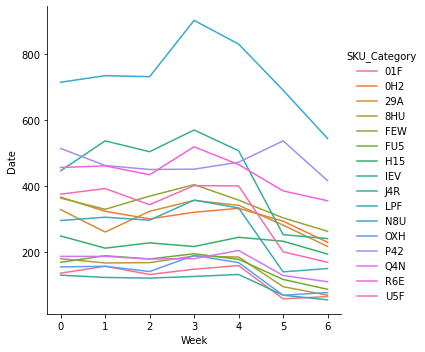

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

tb = filtered_retail.groupby(['Week','SKU_Category'], as_index = False).agg('count')

g = sns.FacetGrid(tb, hue = "SKU_Category", size = 5)
g.map(plt.plot, "Week", "Date")
g.add_legend()

### Part 2: In-Cart Popularity
#### (a) EDA

In [7]:
tb = filtered_retail[filtered_retail.duplicated(['Transaction_ID'], keep = False)]

tb = tb[['Transaction_ID','SKU']]\
    .pivot_table(index = 'Transaction_ID', columns = 'SKU', values = 'SKU',
                 aggfunc = 'size', fill_value = 0)\
    .reset_index(drop = True)

In [8]:
import numpy as np

tb2 = tb.T.dot(tb)
np.fill_diagonal(tb2.values, 0)

In [9]:
pairs = tb2.unstack()\
    .sort_values(ascending = False)\
    .rename_axis(['SKU1','SKU2'])\
    .to_frame('count').reset_index()

pairs = pairs[pairs['count'] > 0]
pairs = pairs[pd.DataFrame(np.sort(pairs[['SKU1','SKU2']].values, 1)).duplicated()]

In [10]:
# pairs.head(5)
# pairs['count'].describe()

tmp = pairs[pairs['count'] > 3]
[sku for sku in item_map['SKU'] if (sku not in tmp['SKU1'].values)]

['GR6UE',
 '81AIS',
 '2NYLG',
 '9VWB9',
 'CCC6P',
 'WG7HI',
 'T311N',
 'COV0L',
 'RBNO8',
 'J2RPB',
 'VXH0U',
 '11H2S',
 'S7QET',
 'L6L4O']

In [11]:
item_map['Item_Name_CHN'] = item_map['Item_ID'].map(dict(zip(menu['Item_ID'], menu['Item_Name_CHN'])))

pairs['Item_ID1'] = pairs['SKU1'].map(dict(zip(item_map['SKU'], item_map['Item_ID'])))
pairs['Item_ID2'] = pairs['SKU2'].map(dict(zip(item_map['SKU'], item_map['Item_ID'])))

pairs['Item_Name1'] = pairs['SKU1'].map(dict(zip(item_map['SKU'], item_map['Item_Name_CHN'])))
pairs['Item_Name2'] = pairs['SKU2'].map(dict(zip(item_map['SKU'], item_map['Item_Name_CHN'])))

#### (b) recommender

In [12]:
tb = filtered_retail[filtered_retail.duplicated(['Transaction_ID'], keep = False)]
tb = tb[['Transaction_ID','SKU']]\
    .pivot_table(index = 'Transaction_ID', columns = 'SKU', values = 'SKU',
                 aggfunc = 'size', fill_value = 0)\
    .reset_index(drop = True)
tb.columns = tb.columns.map(dict(zip(item_map['SKU'], item_map['Item_ID'])))

In [13]:
## lower weight for similar item
def get_similarity(menu, item1, item2):
    l1 = menu.iloc[:, 4:][menu['Item_ID'] == item1].values.tolist()[0]
    l2 = menu.iloc[:, 4:][menu['Item_ID'] == item2].values.tolist()[0]
    
    s = 0
    for i1, i2 in list(zip(l1, l2)):
        s += (i1 == i2)
    return s / len(l1)

## higher weight for seasonal item
def get_seasonal(menu, item):
    return menu['Seasonal'][menu['Item_ID'] == item].values[0]
    
## lower weight for popular item
def get_popular(menu, item):
    return menu['Menu_Category'][menu['Item_ID'] == item].values[0] == 'Signature Series'

In [14]:
def get_recommendations(df, item, similar_cut = 0.9):
    
    ## purchase correlation
    tmp = df.corrwith(df[item]).dropna().to_frame('correlation').reset_index()
    tmp = tmp.sort_values('correlation', ascending = False).reset_index(drop = True)
    
    tmp = tmp[tmp['SKU'] != item]
    tmp = tmp[tmp['correlation'] > 0 ]
    tmp['weight'] = tmp['correlation'] / sum(tmp['correlation'])

    ## ingredient similarity 
    tmp['similarity'] = [get_similarity(menu, item, item2) for item2 in tmp['SKU']]
    tmp = tmp[tmp['similarity'] <  similar_cut]
    
    ## seasonal/popular indicators
    tmp['seasonal'] = [get_seasonal(menu, item2) for item2 in tmp['SKU']]
    tmp['popular'] = [get_popular(menu, item2) for item2 in tmp['SKU']]
    return tmp 

In [15]:
get_recommendations(tb, 'SS1')

,SKU,correlation,weight,similarity,seasonal,popular
1,SS2,0.107431,0.109472,0.875000,0,True
2,SS3,0.067780,0.069067,0.890625,0,True
3,FM1,0.064787,0.066017,0.765625,0,False
4,FM5,0.055805,0.056865,0.765625,0,False
5,FM3,0.054909,0.055952,0.765625,0,False
6,FS4,0.050281,0.051236,0.843750,0,False
7,FM6,0.049684,0.050628,0.796875,0,False
8,FS3,0.044766,0.045616,0.843750,0,False
9,SB6,0.044641,0.045489,0.859375,0,False
10,SS6,0.039549,0.040300,0.781250,1,True
